In [1]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../../'))

import numpy as np
import pandas as pd
import pickle as pkl
from scipy.spatial import distance
import matplotlib, re
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from src.align_representations import Representation, AlignRepresentations, OptimizationConfig, VisualizationConfig

In [2]:
dataset = "demonstration"

In [3]:
def tangled_rope(num_points=100, num_loops=3, radius=1, beta=0.3, pattern=1):
    t = np.linspace(0, 2 * np.pi * num_loops, num_points)

    radius = radius + beta * t / (2 * np.pi)
    
    np.random.seed(pattern)
    noize = np.random.normal(0, 0.07, num_points)
    
    if pattern == 1:
        x = np.sin(t) * radius
        y = np.cos(t) * radius
        z = t / (2 * np.pi)
        
    elif pattern == 2:
        x = np.sin(t) * radius + noize
        y = np.cos(t) * radius + noize
        z = t / (2 * np.pi) + noize
        
    embedding = np.column_stack((x, y, z))


    if pattern == 2:
        # embedding = np.rot90(embedding, 1, axes=(0, 1)).T
        theta_y = np.radians(90)
  
        rot_y = np.array([
            [ np.cos(theta_y), 0, np.sin(theta_y)],
            [0,                1,               0],
            [-np.sin(theta_y), 0, np.cos(theta_y)]
        ])
        
        embedding = (rot_y @ embedding.T).T
    
    return embedding

In [4]:
embedding_1 = tangled_rope(beta=0.3, pattern=1)
embedding_2 = tangled_rope(beta=0.3, pattern=2)

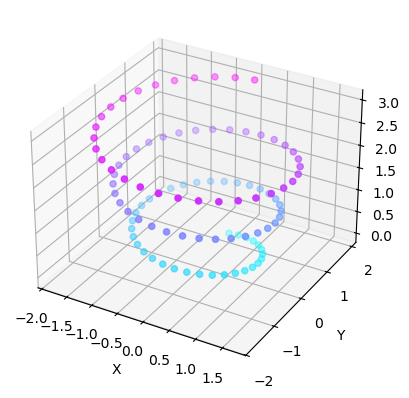

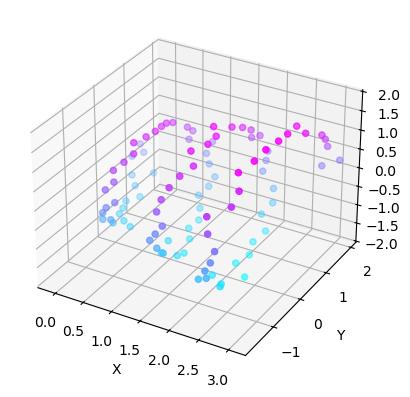

In [5]:
def plot(embedding, pattern=1):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    norm = Normalize(vmin=min(embedding[:, 2]), vmax=max(embedding[:, 2]))
    cmap = plt.get_cmap('cool')
    scalar_map = ScalarMappable(norm=norm, cmap=cmap)
    colors = scalar_map.to_rgba(embedding[:, 2])

    ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=colors)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()
    return colors
    

colors1 = plot(embedding_1, pattern=1)
colors2 = plot(embedding_2, pattern=2)

In [6]:
Group1 = Representation(name="Embeddings X", metric="euclidean", embedding=embedding_1)
Group2 = Representation(name="Embeddings Y", metric="euclidean", embedding=embedding_2)

In [7]:
vis_emb = VisualizationConfig(
    figsize=(10, 10), 
    legend_size=20,
    marker_size=100,
    cbar_ticks_size=20,
    cbar_range=[0, 4],
    color_labels=colors1,
    xlabel="dim1",
    ylabel="dim2",
    zlabel="dim3",
    font="Arial",
    xlabel_size=40,
    ylabel_size=40,
    zlabel_size=40,
    elev=30,
    azim=60,
    fig_ext='svg',
    dpi=300,
)

vis_emb_2 = VisualizationConfig(
    figsize=(10, 10), 
    legend_size=20,
    marker_size=100,
    cbar_ticks_size=20,
    color_labels=colors1,
    xlabel="dim1",
    ylabel="dim2",
    zlabel="dim3",
    font="Arial",
    xlabel_size=40,
    ylabel_size=40,
    zlabel_size=40,
    elev=30,
    azim=60,
    fig_ext='svg',
    dpi=300,
    markers_list=['X'],
    
)

/home/masaru-sasaki/work_space/GWTune/scripts/tutorial_other_datasets/../../src/utils/visualize_functions.py:457: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


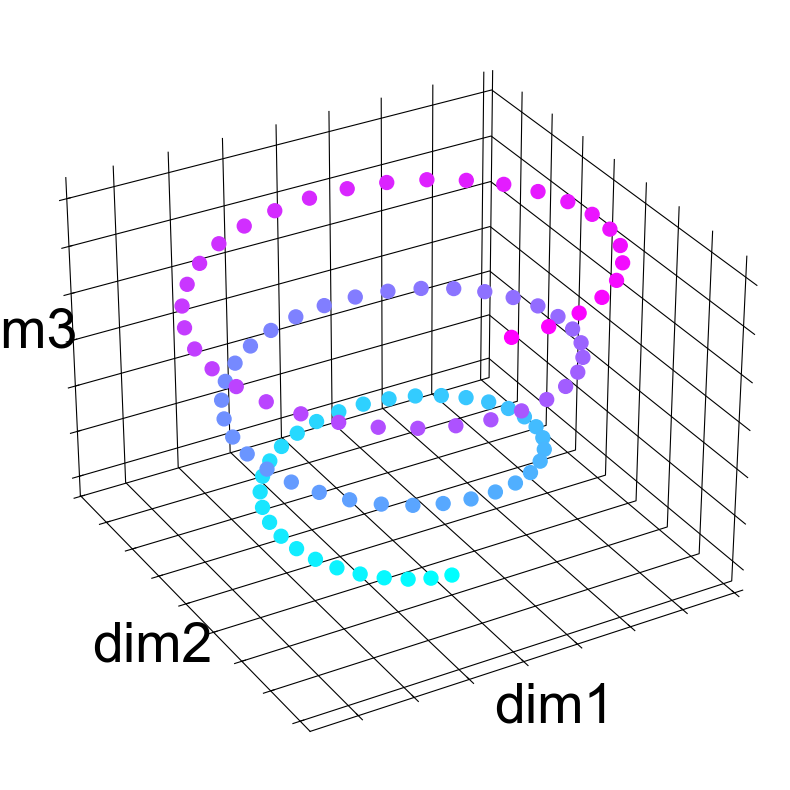

/home/masaru-sasaki/work_space/GWTune/scripts/tutorial_other_datasets/../../src/utils/visualize_functions.py:457: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


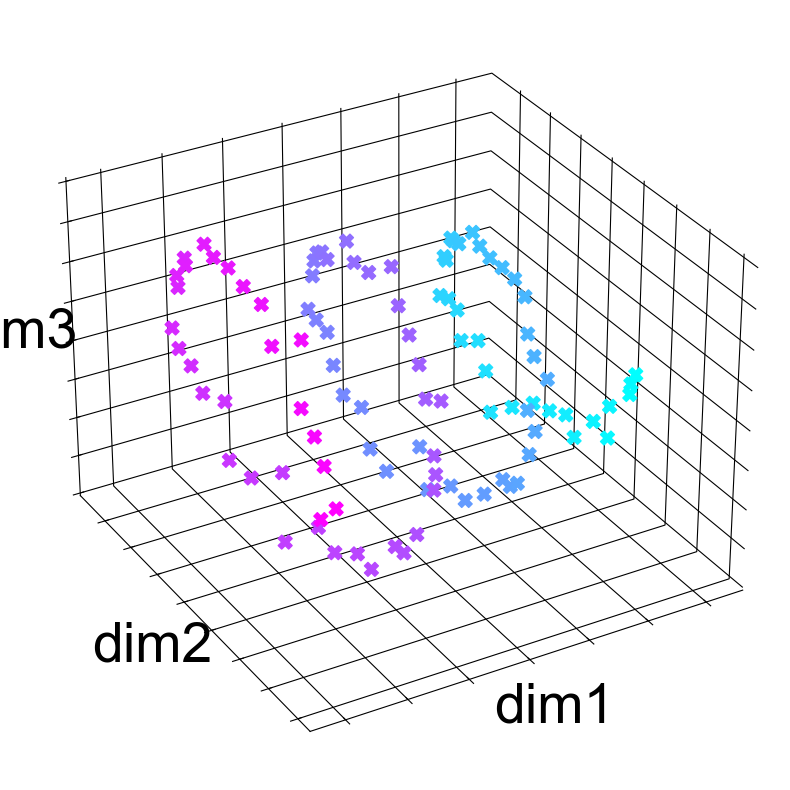

In [8]:
# show embeddings
Group1.show_embedding(dim=3, visualization_config=vis_emb, fig_name="Embeddings X", legend=False)
Group2.show_embedding(dim=3, visualization_config=vis_emb_2, fig_name="Embeddings Y", legend=False)

In [9]:
vis_sim_mat1= VisualizationConfig(
    figsize=(14, 14), 
    title_size = 0, 
    cmap = "rocket_r",
    cbar_ticks_size=60,
    font="Arial",
    xlabel = "100 points",
    ylabel = "100 points",
    xlabel_size=60,
    ylabel_size=60,
    cbar_label="Dissimilarity",
    cbar_label_size=80,
    cbar_range=[0, 4],
    color_labels=colors1,
    color_label_width=5,
    fig_ext='svg',
)

vis_sim_mat2= VisualizationConfig(
    figsize=(14, 14), 
    title_size = 0, 
    cmap = "rocket_r",
    cbar_ticks_size=60,
    font="Arial",
    xlabel = "100 points",
    ylabel = "100 points",
    xlabel_size=60,
    ylabel_size=60,
    cbar_label="Dissimilarity",
    cbar_label_size=80,
    cbar_range=[0, 4],
    color_labels=colors1,
    color_label_width=5,
    fig_ext='svg',
)

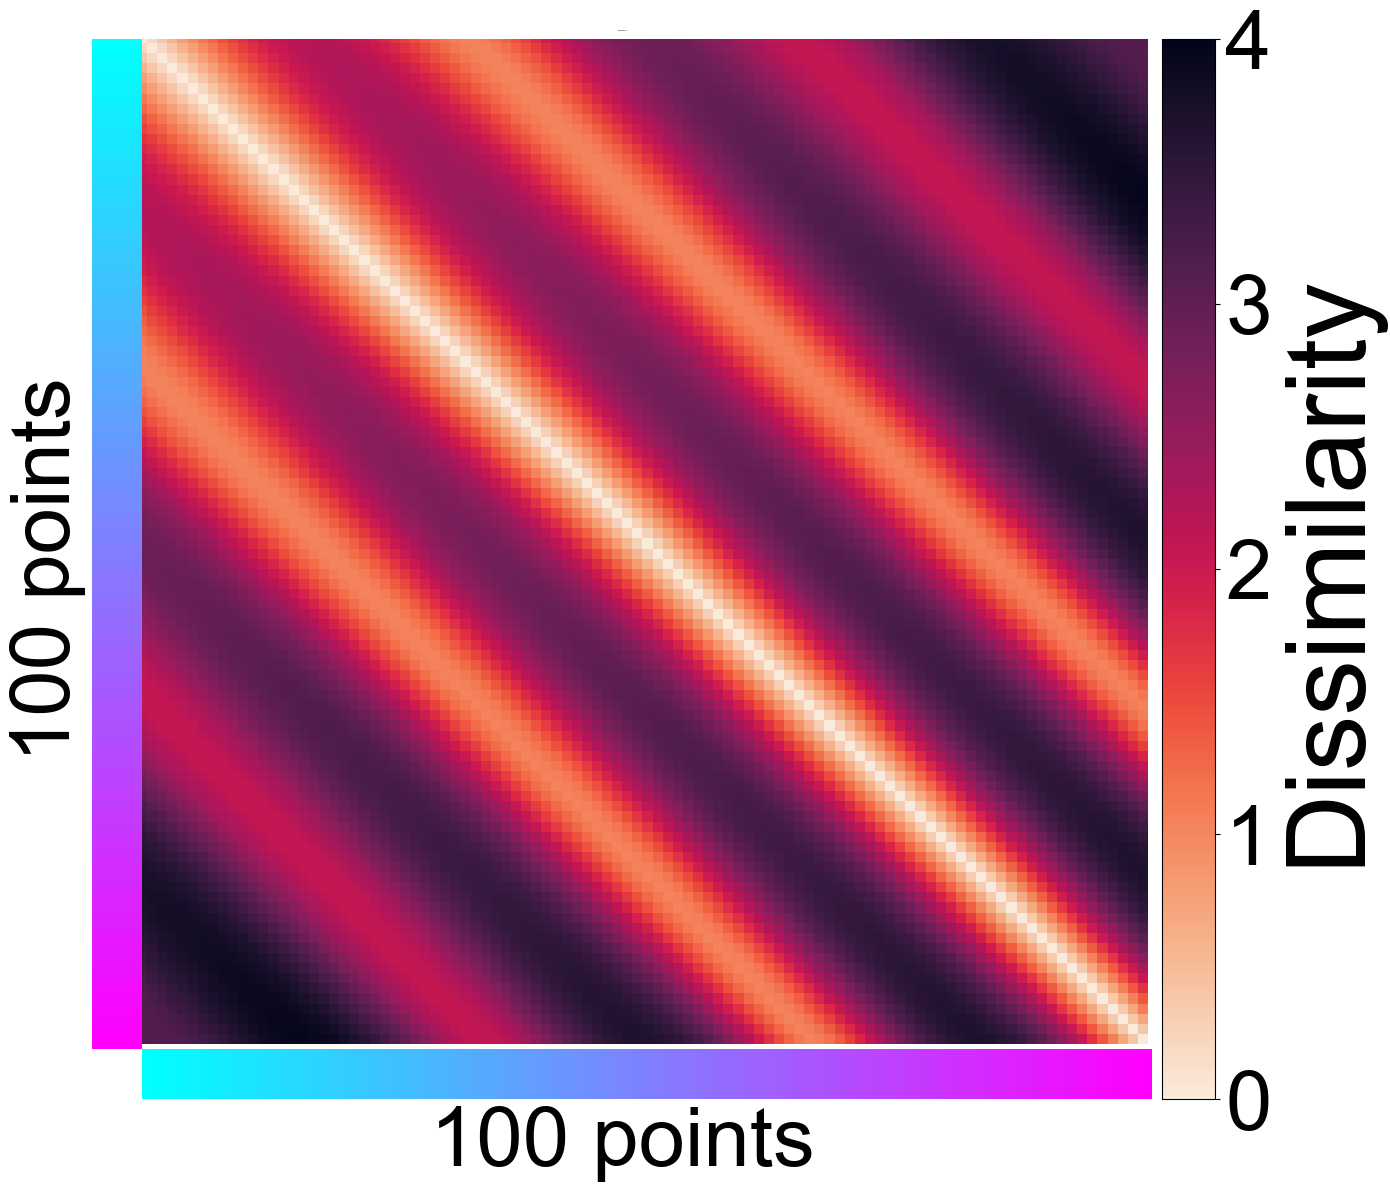

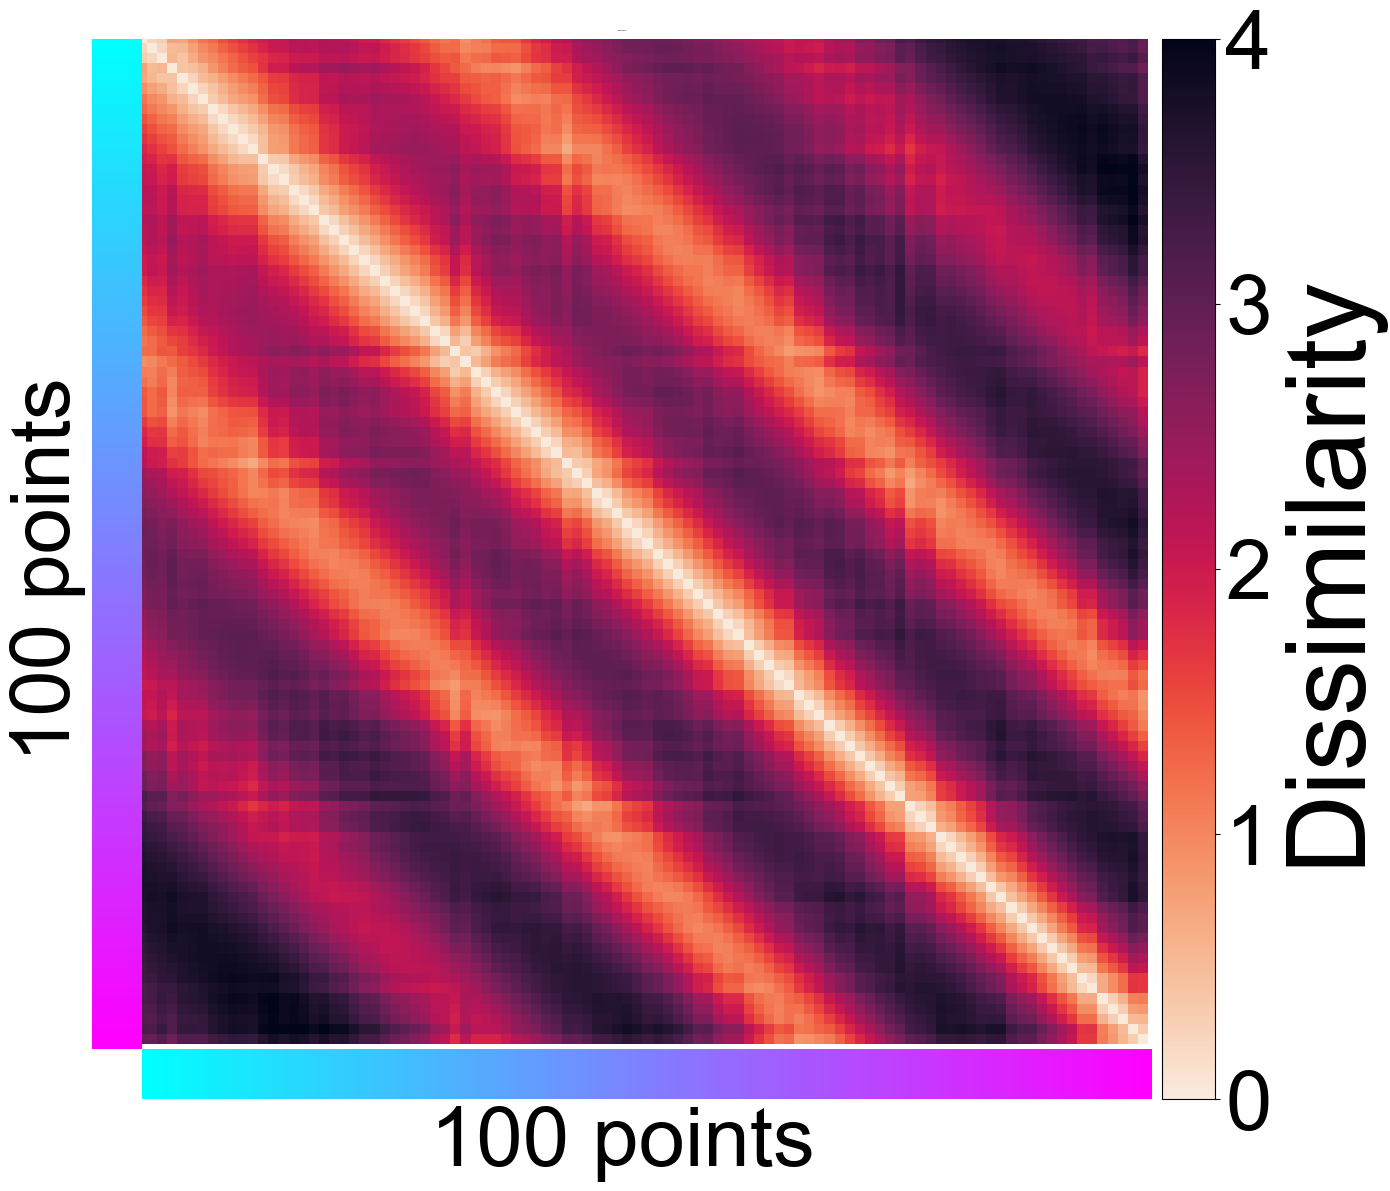

In [10]:
Group1.plot_sim_mat(visualization_config=vis_sim_mat1)
Group2.plot_sim_mat(visualization_config=vis_sim_mat2)

In [11]:
config = OptimizationConfig(
    eps_list=[2e-3, 2e-1],
    num_trial=100,
    sinkhorn_method = 'sinkhorn_log',
    db_params={"drivername": "sqlite"},
    n_iter=1,
)

In [12]:
vis_ot = VisualizationConfig(
    figsize=(14, 14), 
    title_size = 0, 
    cmap = "rocket_r",
    cbar_ticks_size=30,
    font="Arial",
    xlabel = "100 points of Embeddings X",
    ylabel = "100 points of Embeddings Y",
    xlabel_size=60,
    ylabel_size=60,
    cbar_label="Probability",
    cbar_label_size=80,
    color_labels=colors1,
    color_label_width=3,
    fig_ext='svg',
)

In [13]:
vis_log = VisualizationConfig(
    figsize=(8, 6), 
    title_size = 20, 
    cmap = "viridis",
    cbar_ticks_size=20,
    font="Arial",
    xlabel_size=40,
    xticks_size=20,
    ylabel_size=40,
    yticks_size=20,
    cbar_label_size=30,
    marker_size=90,
    plot_eps_log=True,
    fig_ext='svg',
    edgecolor="black",
    linewidth=1,
)

In [14]:
alignment = AlignRepresentations(
    config=config,
    representations_list=[Group1, Group2],
    main_results_dir=f"../../results/{dataset}",
    data_name="demonstration"
)

data_name : demonstration
pairwise_method : combination
All the pairs in the list below will be computed. 
pair: Embeddings X_vs_Embeddings Y eps_list: [0.002, 0.2]


In [15]:
alignment.RSA_get_corr()

Correlation Embeddings X vs Embeddings Y : 0.9938394021170028


In [16]:
compute_OT=False

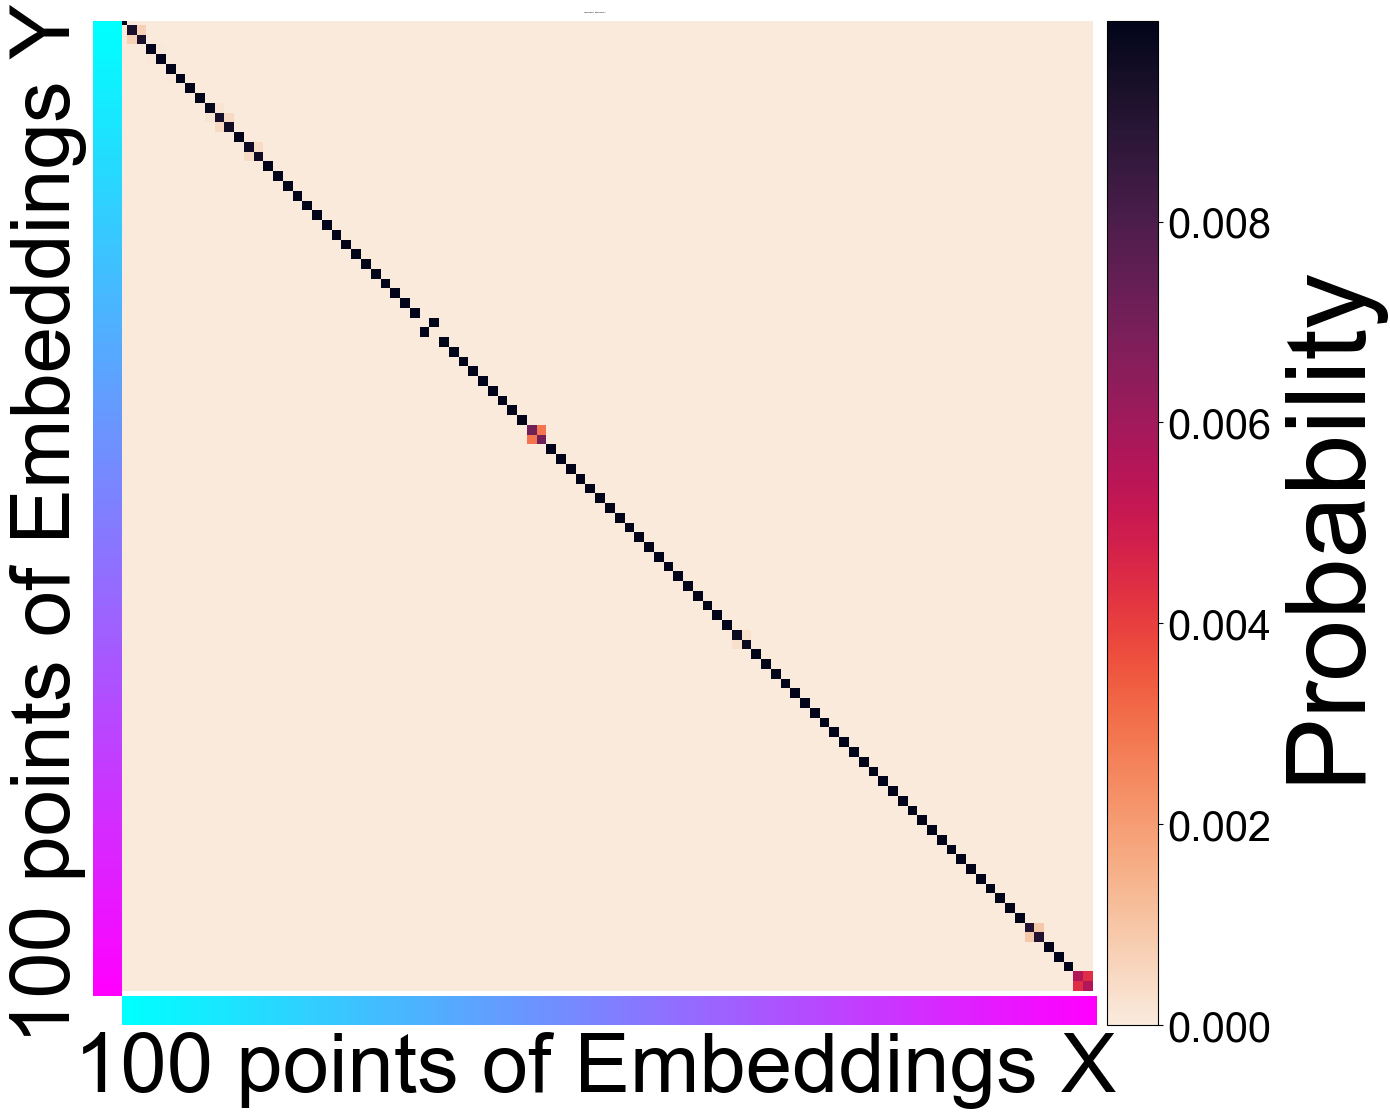

In [17]:
alignment.gw_alignment(
    compute_OT=compute_OT,
    delete_results=False,
    return_figure=True,
    visualization_config=vis_ot,
    sampler_seed=1,
)

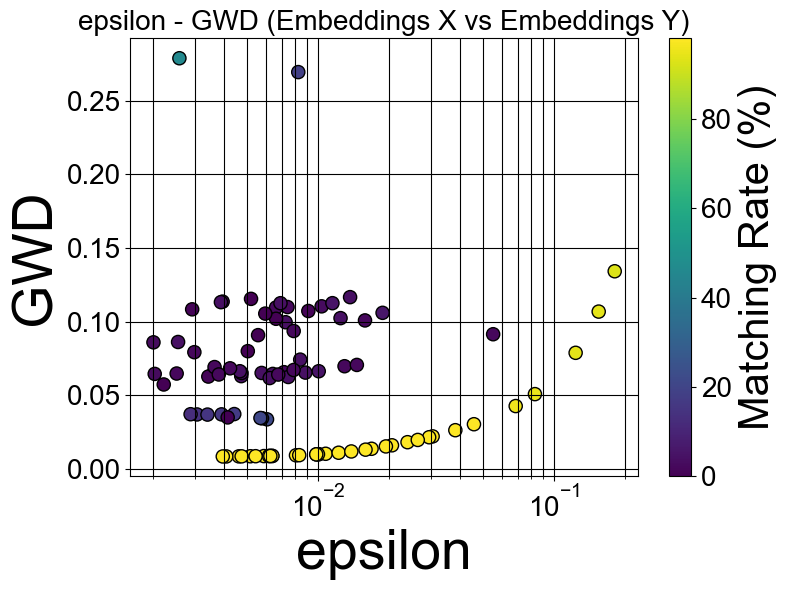

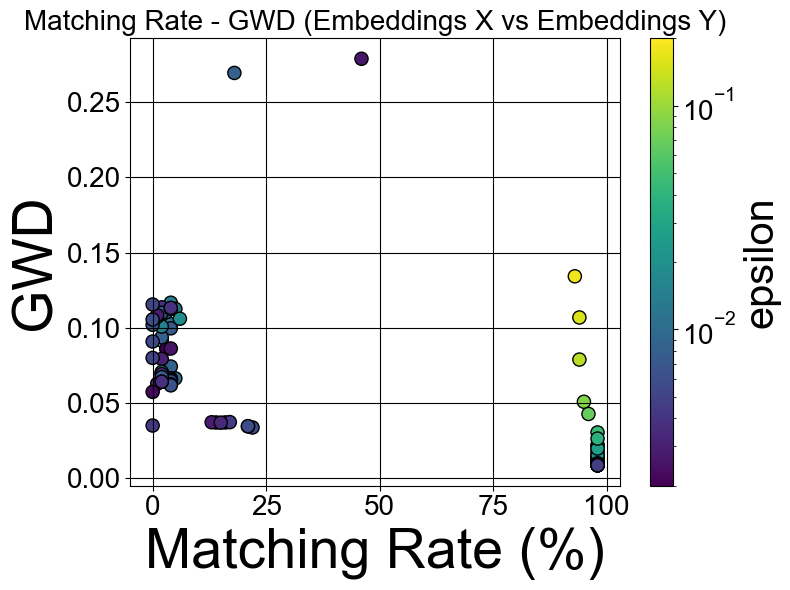

In [18]:
alignment.show_optimization_log(visualization_config=vis_log)

In [19]:
alignment.calc_accuracy(top_k_list=[1, 3, 5], eval_type="ot_plan")

Top k accuracy : 
        Embeddings X_vs_Embeddings Y
top_n                              
1                              98.0
3                             100.0
5                             100.0

Mean : 
 top_n
1   NaN
3   NaN
5   NaN
dtype: float64


In [20]:
study = alignment.pairwise_list[0].study
df_trial = study.trials_dataframe()

In [21]:
print(df_trial.sort_values(by = "value"))

    number     value             datetime_start          datetime_complete  \
74      74  0.008630 2024-10-23 15:16:18.521753 2024-10-23 15:16:36.686961   
70      70  0.008642 2024-10-23 15:14:17.350662 2024-10-23 15:14:31.094603   
53      53  0.008696 2024-10-23 15:10:53.682142 2024-10-23 15:11:07.281227   
99      99  0.008710 2024-10-23 15:24:13.621840 2024-10-23 15:24:27.697348   
36      36  0.008764 2024-10-23 15:07:25.149426 2024-10-23 15:07:38.427899   
..     ...       ...                        ...                        ...   
54      54       NaN 2024-10-23 15:11:07.306924 2024-10-23 15:11:20.777530   
56      56       NaN 2024-10-23 15:11:31.351899 2024-10-23 15:11:53.690655   
65      65       NaN 2024-10-23 15:13:13.685067 2024-10-23 15:13:34.692865   
72      72       NaN 2024-10-23 15:15:02.442086 2024-10-23 15:15:20.685235   
92      92       NaN 2024-10-23 15:22:22.373495 2024-10-23 15:22:35.950506   

                 duration  params_eps  user_attrs_best_acc  \
7

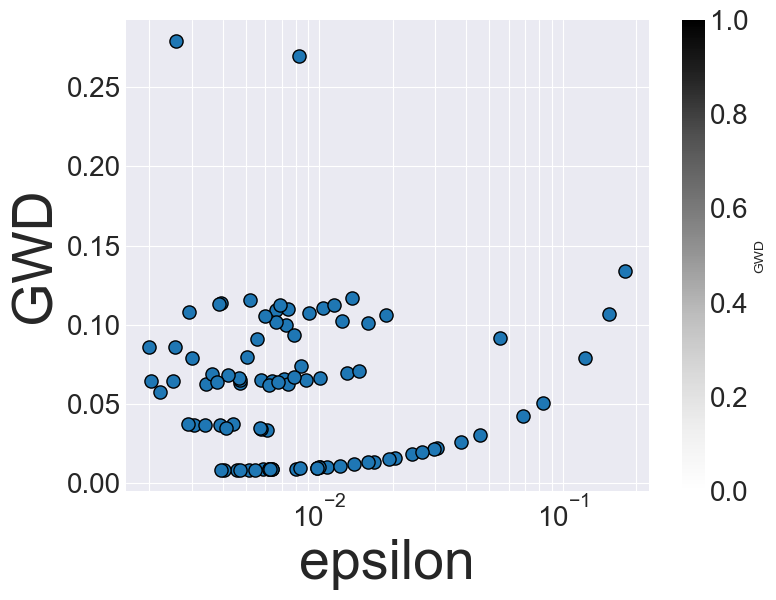

In [22]:
plt.style.use("default")
plt.rcParams["grid.color"] = "black"
plt.rcParams['font.family'] = "Arial"
plt.rcParams.update(plt.rcParamsDefault)
styles = matplotlib.style.available
darkgrid_style = [s for s in styles if re.match(r"seaborn-.*-darkgrid", s)][0]
plt.style.use(darkgrid_style)

plt.figure(figsize=(8,6))
plt.scatter(df_trial["params_eps"], df_trial["value"], s = 90, edgecolor="black", linewidth=1)
plt.xlabel("epsilon", fontsize=40)
plt.ylabel("GWD", fontsize=40)
plt.xscale('log')

plt.tick_params(axis='x', which='both', labelsize=20, rotation=0)
plt.tick_params(axis='y', which='major', labelsize=20)
plt.grid(True, which="both")
plt.tight_layout()
cbar = plt.colorbar(label="GWD")
cbar.ax.tick_params(labelsize=20)
plt.savefig(f"../../results/{dataset}/eps_gwd.svg")
plt.show()

In [23]:
vis_emb3d = VisualizationConfig(
    figsize=(8, 8), 
    legend_size=20,
    marker_size=60,
    color_labels=colors1,
    fig_ext='svg',
    markers_list=['o', 'X'],
    xlabel="dim1",
    ylabel="dim2",
    zlabel="dim3",
    font="Arial",
    cmap="cool",
    colorbar_shrink=0.8,
    xlabel_size=40,
    ylabel_size=40,
    zlabel_size=40,
)

No category information is given.


/home/masaru-sasaki/work_space/GWTune/scripts/tutorial_other_datasets/../../src/utils/visualize_functions.py:457: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


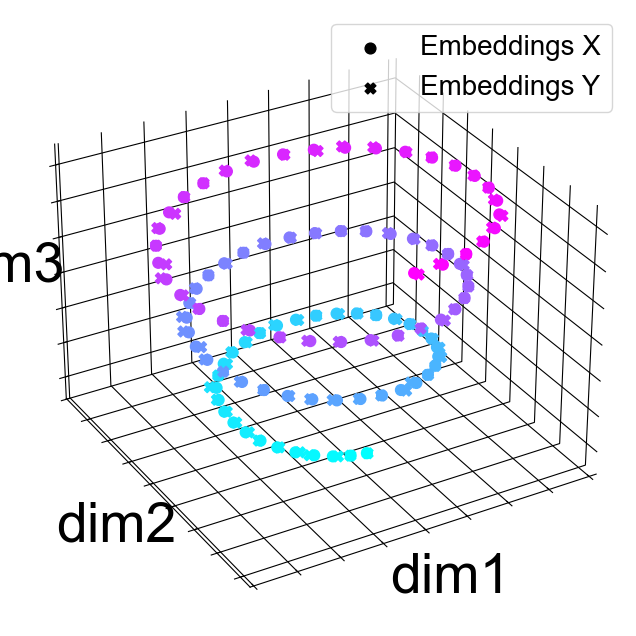

In [24]:
alignment.visualize_embedding(
    dim=3, 
    pivot=0, 
    visualization_config=vis_emb3d, 
)